## Decision Trees and Random Forest
### Predicting High Future Healthcare Costs

**Using high future healthcare expenditures as a proxy for worsening health, this decision tree model will predict whether or not someone's health is expected to worsen in the future. The goal in predicting this is that if physicians and medicare service providers can predict someone's future health to decline, they can offer that beneficiary preventative services.**

In this section, we use the encoded version of our data to predict whether or not a patients 2010 reimbursements would be considered "High", "Medium", or "Low". 

In [191]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import pipeline as pipe
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(rc={'figure.figsize':(11, 4)})

In [192]:
claims_categorical = pipe.read_all(True)

In [193]:
claims_categorical.head()

,reimb2010,reimb2008,reimb2009,age2010,male,heart.failure,kidney,cancer,copd,depression,...,race_Black,race_Hispanic,race_Other,race_White,log(reimb2010+1),log(reimb2009+1),log(reimb2008+1),cost_level_High,cost_level_Low,cost_level_Medium
0,390,320.0,360,97,0,0,0,0,0,0,...,0,0,0,1,2.592177,2.557507,2.506505,0,1,0
1,970,58800.0,2740,79,0,1,1,0,1,0,...,0,0,0,1,2.987219,3.437909,4.769385,0,1,0
2,5630,510.0,1580,87,0,1,0,0,0,0,...,0,0,0,1,3.750586,3.198932,2.708421,0,0,1
3,3480,2930.0,49330,79,0,1,1,0,1,1,...,0,0,0,1,3.541704,4.693120,3.467016,0,0,1
4,920,1500.0,1650,85,1,1,0,1,0,0,...,0,0,0,1,2.964260,3.217747,3.176381,0,1,0


**Below are the distributions of 2010 reimbursements for those patients classified into each group**

### High Expenditures

In [194]:
claims_categorical[claims_categorical['cost_level_High'] == 1]['reimb2010'].describe()

count     21376.000000
mean      34341.456774
std       13624.262427
min       20730.000000
25%       24110.000000
50%       29860.000000
75%       40020.000000
max      160500.000000
Name: reimb2010, dtype: float64

### Medium Expenditures

In [195]:
claims_categorical[claims_categorical['cost_level_Medium'] == 1]['reimb2010'].describe()

count    235311.000000
mean       6581.778497
std        4285.087658
min        2620.000000
25%        3390.000000
50%        4820.000000
75%        8450.000000
max       20720.000000
Name: reimb2010, dtype: float64

### Low Expenditures

In [196]:
claims_categorical[claims_categorical['cost_level_Low'] == 1]['reimb2010'].describe()

count    767261.000000
mean        819.371205
std         758.823339
min           0.000000
25%          80.000000
50%         660.000000
75%        1380.000000
max        2610.000000
Name: reimb2010, dtype: float64

Note: The last column appears to be processed.
Will remove this column because otherwise it dominates the CART model

In [197]:
claims_categorical['Cost Category'] = claims_categorical["reimb2010"].apply(lambda row: 3 if row >= 20730
                                                else (2 if row < 20730 and row >= 2620
                                                else 1))

In [198]:
claims_categorical.columns

Index(['reimb2010', 'reimb2008', 'reimb2009', 'age2010', 'male',
       'heart.failure', 'kidney', 'cancer', 'copd', 'depression', 'diabetes',
       'ihd', 'osteoporosis', 'arthritis', 'stroke', 'InpatientClaims',
       'OutpatientClaims', 'OfficeVisit', 'EyeExam', 'EKG', 'xray', 'CTScan',
       'PhysicalTherapy', 'Ambulance', 'acuity', 'costTrend',
       'monthsWithClaims', 'race_Black', 'race_Hispanic', 'race_Other',
       'race_White', 'log(reimb2010+1)', 'log(reimb2009+1)',
       'log(reimb2008+1)', 'cost_level_High', 'cost_level_Low',
       'cost_level_Medium', 'Cost Category'],
      dtype='object')

In [199]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

**We choose to use the features in our decision tree that we determined were important based on exploration of feature importance in the regularization notebook**

In [200]:
cols_norm = ["age2010", "OfficeVisit", "EyeExam", "EKG", "xray", "CTScan", "PhysicalTherapy",
             "Ambulance", "acuity", "costTrend", "monthsWithClaims", 
             "log(reimb2010+1)", "log(reimb2009+1)", "log(reimb2008+1)"]

In [201]:
train, test = train_test_split(claims_categorical, test_size=0.3, random_state=0)

train, test = pipe.normalize(train, test, cols_norm)

labels = train[['log(reimb2009+1)', 'log(reimb2008+1)',
               'age2010', 'male',
       'heart.failure', 'kidney', 'cancer', 'copd', 'depression', 'diabetes',
       'ihd', 'osteoporosis', 'arthritis', 'stroke', 'InpatientClaims',
       'OutpatientClaims', 'OfficeVisit', 'EyeExam', 'EKG', 'xray', 'CTScan',
       'PhysicalTherapy', 'Ambulance', 'acuity', 'costTrend',
       'monthsWithClaims', 'race_Black', 'race_Hispanic', 'race_Other',
       'race_White']].columns.values

X_train = train[['log(reimb2009+1)', 'log(reimb2008+1)',
               'age2010', 'male',
       'heart.failure', 'kidney', 'cancer', 'copd', 'depression', 'diabetes',
       'ihd', 'osteoporosis', 'arthritis', 'stroke', 'InpatientClaims',
       'OutpatientClaims', 'OfficeVisit', 'EyeExam', 'EKG', 'xray', 'CTScan',
       'PhysicalTherapy', 'Ambulance', 'acuity', 'costTrend',
       'monthsWithClaims', 'race_Black', 'race_Hispanic', 'race_Other',
       'race_White']].values

y_train = train['Cost Category'].values

X_test = test[['log(reimb2009+1)', 'log(reimb2008+1)',
               'age2010', 'male',
       'heart.failure', 'kidney', 'cancer', 'copd', 'depression', 'diabetes',
       'ihd', 'osteoporosis', 'arthritis', 'stroke', 'InpatientClaims',
       'OutpatientClaims', 'OfficeVisit', 'EyeExam', 'EKG', 'xray', 'CTScan',
       'PhysicalTherapy', 'Ambulance', 'acuity', 'costTrend',
       'monthsWithClaims', 'race_Black', 'race_Hispanic', 'race_Other',
       'race_White']].values

y_test = test['Cost Category'].values

In [202]:
pipeline = Pipeline([("dec_tree", DecisionTreeClassifier(random_state = 0))])

In [203]:
criterion = ["gini", "entropy"]
max_depth = [1,2,5]
min_samples_split = [2,4,8]
parameters = {
    "dec_tree__criterion" : criterion,
    "dec_tree__max_depth" : max_depth,
    "dec_tree__min_samples_split" : min_samples_split
}

In [204]:
grid_model = GridSearchCV(estimator=pipeline, 
                          param_grid=parameters, 
                          cv=10,
                          return_train_score=True,
                          scoring='accuracy',
                          iid=True)

In [205]:
grid_model_result = grid_model.fit(X_train, y_train)

high_cost = grid_model.predict(X_test)

/Users/jacob/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


In [206]:
mse_grid = metrics.mean_squared_error(y_test, high_cost)

print("""
MSE (Grid Search):\t{}
""".format(mse_grid))

cv_results = pd.DataFrame(grid_model.cv_results_)
ranked_cv = cv_results.sort_values(by='mean_train_score', ascending = False)


MSE (Grid Search):	0.2833276364405814



In [207]:
ranked_cv.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dec_tree__criterion,param_dec_tree__max_depth,param_dec_tree__min_samples_split,params,split0_test_score,split1_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
6,5.859780,1.105813,0.015204,0.003558,gini,5,2,"{'dec_tree__criterion': 'gini', 'dec_tree__max...",0.756882,0.757286,...,0.757301,0.757972,0.757961,0.757980,0.757197,0.757366,0.758014,0.758716,0.757731,0.000452
7,5.460526,0.630785,0.016584,0.011108,gini,5,4,"{'dec_tree__criterion': 'gini', 'dec_tree__max...",0.756882,0.757286,...,0.757301,0.757972,0.757961,0.757980,0.757197,0.757366,0.758014,0.758716,0.757731,0.000452
8,6.061886,1.337485,0.014070,0.002536,gini,5,8,"{'dec_tree__criterion': 'gini', 'dec_tree__max...",0.756882,0.757286,...,0.757301,0.757972,0.757961,0.757980,0.757197,0.757366,0.758014,0.758716,0.757731,0.000452
17,5.944273,0.820122,0.016108,0.009300,entropy,5,8,"{'dec_tree__criterion': 'entropy', 'dec_tree__...",0.756058,0.753784,...,0.756618,0.756577,0.756517,0.756521,0.756433,0.756538,0.753452,0.755227,0.755968,0.000992
16,7.140856,1.155191,0.015565,0.004137,entropy,5,4,"{'dec_tree__criterion': 'entropy', 'dec_tree__...",0.756058,0.753784,...,0.756618,0.756577,0.756517,0.756521,0.756433,0.756538,0.753452,0.755227,0.755968,0.000992


In [208]:
grid_model.best_estimator_[0]

DecisionTreeClassifier(max_depth=5, random_state=0)

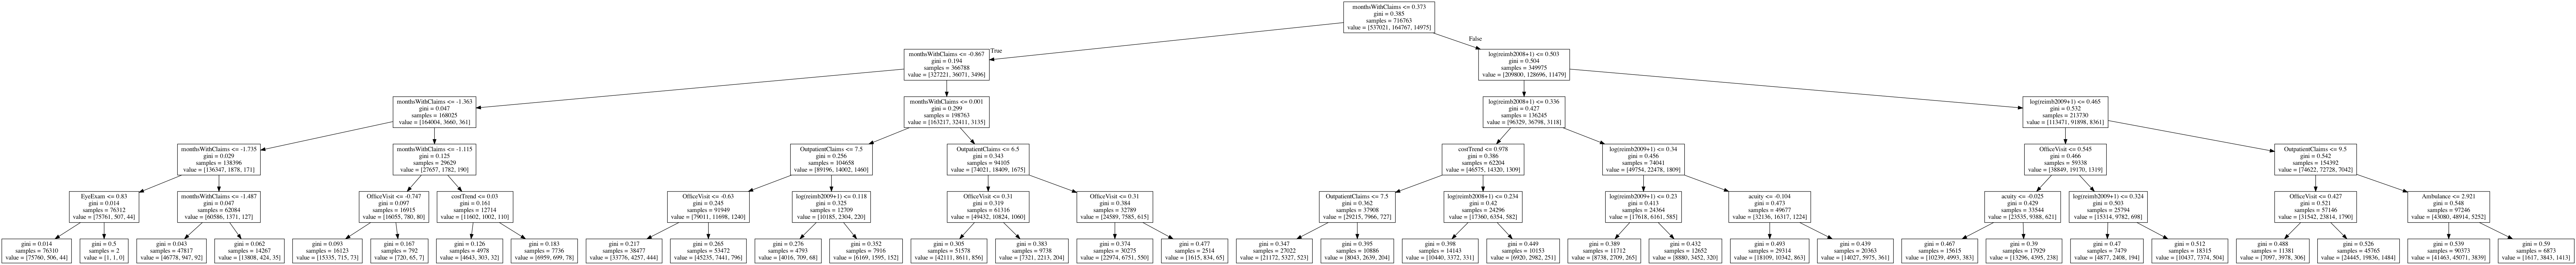

In [209]:
from sklearn import tree
import pydotplus
from IPython.display import Image

dt = DecisionTreeClassifier(max_depth=5, random_state=0)
model = dt.fit(X_train, y_train)

dot_data = tree.export_graphviz(dt, out_file=None, feature_names=labels)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [210]:
y_pred = dt.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[211502  18738      0]
 [ 49589  20955      0]
 [  4102   2299      0]]


/Users/jacob/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       0.80      0.92      0.85    230240
           2       0.50      0.30      0.37     70544
           3       0.00      0.00      0.00      6401

    accuracy                           0.76    307185
   macro avg       0.43      0.41      0.41    307185
weighted avg       0.71      0.76      0.73    307185



## Random Forest

In [211]:
claims_sample = claims_categorical.sample(frac=0.005, random_state=0)

labels = claims_sample[['log(reimb2009+1)', 'log(reimb2008+1)',
               'age2010', 'male',
       'heart.failure', 'kidney', 'cancer', 'copd', 'depression', 'diabetes',
       'ihd', 'osteoporosis', 'arthritis', 'stroke', 'InpatientClaims',
       'OutpatientClaims', 'OfficeVisit', 'EyeExam', 'EKG', 'xray', 'CTScan',
       'PhysicalTherapy', 'Ambulance', 'acuity', 'costTrend',
       'monthsWithClaims', 'race_Black', 'race_Hispanic', 'race_Other',
       'race_White']].columns.values

features = claims_sample[['log(reimb2009+1)', 'log(reimb2008+1)',
               'age2010', 'male',
       'heart.failure', 'kidney', 'cancer', 'copd', 'depression', 'diabetes',
       'ihd', 'osteoporosis', 'arthritis', 'stroke', 'InpatientClaims',
       'OutpatientClaims', 'OfficeVisit', 'EyeExam', 'EKG', 'xray', 'CTScan',
       'PhysicalTherapy', 'Ambulance', 'acuity', 'costTrend',
       'monthsWithClaims', 'race_Black', 'race_Hispanic', 'race_Other',
       'race_White']].values

target = claims_sample['Cost Category'].values

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

In [212]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [213]:
# by default majority class (benign) will be negative
lb = LabelBinarizer()
claims_sample['Cost Category'] = lb.fit_transform(claims_sample['Cost Category'].values)
targets = claims_sample['Cost Category']

features = claims_sample[['log(reimb2009+1)', 'log(reimb2008+1)',
               'age2010', 'male',
       'heart.failure', 'kidney', 'cancer', 'copd', 'depression', 'diabetes',
       'ihd', 'osteoporosis', 'arthritis', 'stroke', 'InpatientClaims',
       'OutpatientClaims', 'OfficeVisit', 'EyeExam', 'EKG', 'xray', 'CTScan',
       'PhysicalTherapy', 'Ambulance', 'acuity', 'costTrend',
       'monthsWithClaims', 'race_Black', 'race_Hispanic', 'race_Other',
       'race_White']]

X_train, X_test, y_train, y_test = train_test_split(features, targets, stratify=targets)

In [214]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [215]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    
    return grid_search

In [216]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')


Best params for precision_score
{'max_depth': 25, 'max_features': 20, 'min_samples_split': 3, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg        90       224
pos        89       877


In [217]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
         'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
90,0.799,0.921,0.766,25,20,3,100
93,0.799,0.922,0.766,25,20,5,300
88,0.798,0.928,0.768,25,10,10,100
86,0.798,0.930,0.770,25,10,5,100
84,0.798,0.927,0.767,25,10,3,100


In [218]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Best params for recall_score
{'max_depth': 3, 'max_features': 3, 'min_samples_split': 10, 'n_estimators': 100}

Confusion matrix of Random Forest optimized for recall_score on the test data:
     pred_neg  pred_pos
neg         3       311
pos         9       957


In [219]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_precision_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score',
         'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

,mean_test_precision_score,mean_test_recall_score,mean_test_accuracy_score,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators
86,0.799,0.931,0.771,25,10,5,100
66,0.799,0.923,0.766,15,20,3,100
92,0.798,0.920,0.764,25,20,5,100
88,0.798,0.928,0.768,25,10,10,100
70,0.797,0.927,0.767,15,20,10,100
